### Model Development

    This note book covers the model development for predicting the unit price. 

    Details and decisions are explained in comments

In [1]:
## load the libraries for computation
import pandas as pd
import numpy as np

# Load the libraries for plotting
import seaborn as sns 
import matplotlib.pyplot as plt

# Yellowbricks for visualization
from yellowbrick.regressor import PredictionError

# encoding
from sklearn.preprocessing import LabelEncoder

# to split the data 
from sklearn.model_selection import  train_test_split

# model 
from sklearn.ensemble import RandomForestRegressor # baseline model
from xgboost import XGBRegressor    # model enhancement

# metrics and tuning
from sklearn.model_selection import RepeatedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

In [2]:
# load the data 
df =pd.read_csv("step1_prepared_data.csv")
del df['Unnamed: 0'] # delete the noise
print("This is the shape of the data", df.shape)
df.head(1) 

This is the shape of the data (46125, 28)


,booking_to_delivery_date,unit_price_inK,type_of_sale,date_of_sale,mode_of_transport,no_of_units,cust_group_name,cust_segment_name,Customer_Id,delivery_month_from,...,plant_country_name,most_expensive_part_l1,most_expensive_part_l2,shipto_city,shipto_nr,soldto_city,soldto_nr,car_nr,shipto_country,soldto_country
0,long,1662.54,retail,2159-09-26,Truck,2640.0,aa,Prime,953.0-952.0,2160-04-01,...,Philippines,bonnet,bonner,Algeria,953,Algeria,952,Pag99992258,Algeria,Algeria


## Feature Engineering 

In [3]:
## change the . with "Not_Defined" value
df['colour'] = df['colour'].replace('.' , "Not_Defined")

In [4]:
## we append the second_recent_transcation and attach to the model 
df = df.sort_values("date_of_sale", ascending=False)

df['second_most_recent'] = df.groupby('Customer_Id')['unit_price_inK'].shift(1)  # created new feature

# it will be null for the recent one # we can impute with 0
df[['unit_price_inK', 'second_most_recent']].head()

,unit_price_inK,second_most_recent
7548,444.870096,NaN
10502,1568.160000,NaN
7597,335.313165,444.870096
7547,461.317758,335.313165
7535,187.725692,461.317758


In [5]:
#  These columns represnt same level of numbers - May be zip codes etc.
# we can convert them into  label encodes for this model  --- Needs to be discussed with SMEs
df['plant_nr'] = df['plant_nr'].astype("str")
df['shipto_nr'] = df['shipto_nr'].astype("str")
df['soldto_nr'] = df['soldto_nr'].astype("str")

In [6]:
# fill na in second most recent transations 
df.fillna(0, inplace= True)
print("Is there any null value in dataframe:..", df.isna().sum().any())

Is there any null value in dataframe:.. False


## Before moving forward for feature encoding, we need to have a look on data skewness as model will be impacted with the dependent feature's skewness
Skewness treatment is done within feature engineering steps

## Skew Test 
Need to do a test for skeness for the data here as it still  might have more outliers 
- There are many methods such as  Log Transformation , Box Cox Transformation etc. Log Transfromation is used here 

In [7]:
df.skew().sort_values(ascending = False) # data skewness is there  

second_most_recent    32.698650
unit_price_inK        32.113736
no_of_units           10.168847
plant_nr               1.115528
soldto_nr             -1.467462
shipto_nr             -1.467661
dtype: float64

In [8]:
## Re-validation that there is no negative value
df.describe()

,unit_price_inK,no_of_units,second_most_recent
count,46125.000000,46125.000000,46125.000000
mean,2643.188284,2572.755295,2580.393449
std,10838.148132,6443.660392,10705.715649
min,0.220000,0.022000,0.000000
25%,702.973590,440.000000,675.994513
50%,1421.420000,878.680000,1388.200000
75%,2559.520656,2200.000000,2512.840000
max,542006.080000,184800.000000,542006.080000


/Users/oncemore/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


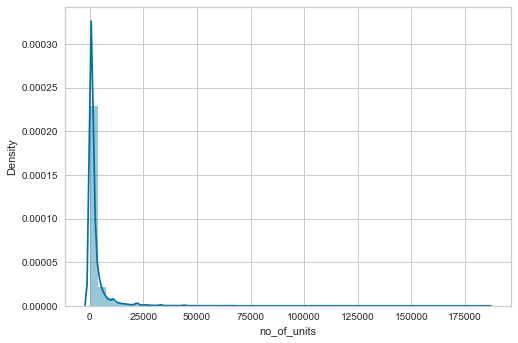

In [9]:
## no of units outliers shall be handled properly 
sns.distplot(df['no_of_units'], kde = True)
plt.show()

/Users/oncemore/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


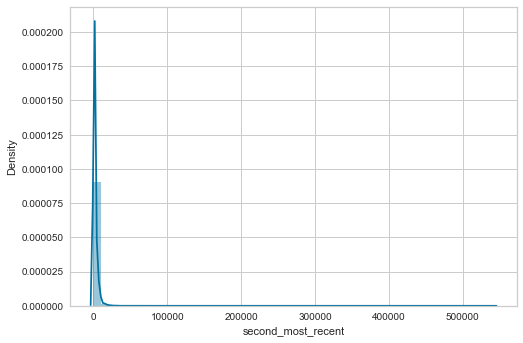

In [10]:
## no of units outliers shall be handled properly 
sns.distplot(df['second_most_recent'], kde = True)
plt.show()

/Users/oncemore/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


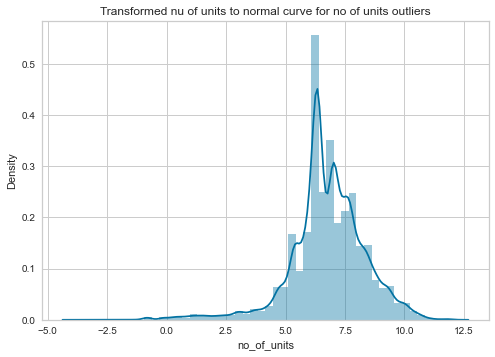

In [11]:
#  We are using log transformation  for outliers management in the dataset
df['no_of_units'] = np.log(df['no_of_units'])
plt.title("Transformed nu of units to normal curve for no of units outliers")
sns.distplot(df['no_of_units'], kde = True)
plt.show()

## 
the second most recent transaction is having minimum as zeros due to some logically missing  values, so we need to use log+1

/Users/oncemore/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


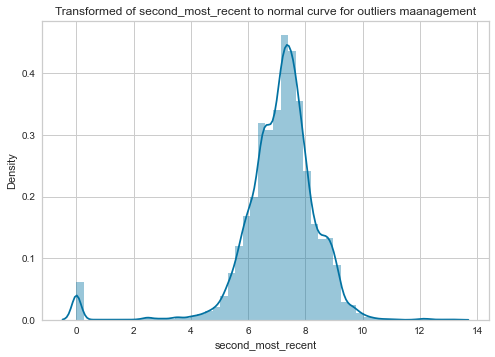

In [12]:
#  We are using log transformation  for outliers management in the dataset
df['second_most_recent'] = np.log(df['second_most_recent'] +1 )
plt.title("Transformed of second_most_recent to normal curve for outliers maanagement")
sns.distplot(df['second_most_recent'], kde = True)
plt.show()

## Feature Encoding
Now, Feature needs to be encoded. One hot encoding and Label encoding is used.  These method can still be experimented based on the model results. 

In [13]:
# Drop these columns from the data as does not add value for model
drop_list = ["car_nr" , "Customer_Id", 'cust_group_name']
df.drop(drop_list, inplace= True, axis =1)

In [14]:
## label encoding - OHE encoding 
## label encoding is used for zips and addresses - Better way would be OHE but dimension can go very high
## so we will settle down with the Label Encoding

## list of the colums ready for different set of encoding 
ohe_features = ['booking_to_delivery_date', 'mode_of_transport', 'cust_segment_name',
                'type', 'item_class_l1', 'item_class_l2', 'item_class_l3', 'plant_country_name', 
                'most_expensive_part_l1', 'most_expensive_part_l2', 'shipto_country', 'soldto_country']
label_encoding = ['colour', 'plant_city', "shipto_city", "soldto_city"]

date_columns = ['date_of_sale', 'delivery_month_from', 'delivery_month_to']

'''Type of the encoding and decisions taken'''
## Transport label encoding - truck get highest and others in order of occurance
## booking_to_delivery - OHE
## cust_segment_name - OHE ( Data will be sparse for two values )
## colour - label encoding and . get highest number 
## type - OHE
## item_class_l1 - OHE
## item_class_l2 - OHE Brand
## item_class_l2 - OHE - Brand series (more data but it matters)

## most_expensive_part_l1  - OHE 
## most_expensive_part_l2 -  OHE

'Type of the encoding and decisions taken'

In [15]:
## Create a dataframe of one hot encoding of features
# select features and data
ohe_pd  = df[ohe_features]

## use get_dummies for the create encoded features
ohe_pd_developed = pd.get_dummies(ohe_pd)
ohe_pd_developed.head(1)

,booking_to_delivery_date_immediate,booking_to_delivery_date_long,booking_to_delivery_date_medium,booking_to_delivery_date_short,mode_of_transport_Barge,mode_of_transport_Container,mode_of_transport_Other,mode_of_transport_Seavessel,mode_of_transport_Truck,cust_segment_name_Excellent,...,soldto_country_Mozambique,soldto_country_Namibia,soldto_country_Niger,soldto_country_Nigeria,soldto_country_Senegal,soldto_country_Somalia,soldto_country_South Africa,soldto_country_Sudan,soldto_country_Tanzania,soldto_country_Zambia
7548,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# intiate sklearn label encoder 
le = LabelEncoder()

# Add label encoder to the selected features 
df['colour'] = le.fit_transform(df['colour'])
df['plant_city'] = le.fit_transform(df['plant_city'])
df['shipto_city'] = le.fit_transform(df['shipto_city'])
df['soldto_city'] = le.fit_transform(df['soldto_city'])

Make dataframe ready for model experiment

In [17]:
## list of feature we will select from the dataset 
fetaure_list = ["type_of_sale", 'unit_price_inK', 'second_most_recent', 'no_of_units', 'colour', 'plant_city',
               "shipto_city", "soldto_city"]

df = df[fetaure_list]

# Prepare final dataset for baseline model
df_model_ready = df.join(ohe_pd_developed)
print("shape of the baseline dataset", df_model_ready.shape)
df_model_ready.head(1) # look on dataset

shape of the baseline dataset (46125, 220)


,type_of_sale,unit_price_inK,second_most_recent,no_of_units,colour,plant_city,shipto_city,soldto_city,booking_to_delivery_date_immediate,booking_to_delivery_date_long,...,soldto_country_Mozambique,soldto_country_Namibia,soldto_country_Niger,soldto_country_Nigeria,soldto_country_Senegal,soldto_country_Somalia,soldto_country_South Africa,soldto_country_Sudan,soldto_country_Tanzania,soldto_country_Zambia
7548,wholesale,444.870096,0.0,7.869098,16,14,165,118,0,1,...,0,0,0,0,0,0,0,0,0,0


## Assignment Ask
Create a dataset of retail - type of sales and predict the car price for retail customer based on Only Retail data 

In this model, input will be retail data only. But model will be trained with both wholesale and retail customers.

Later, we can have a look on if we need to build a model only with retail customers and see the importance. (Why so, becuase retail data records are less)

#### Prepare final validation set of retail cars with retail data

In [18]:
# Take out 300 data points 
df_test = df_model_ready[:300]

In [19]:
## Split data for test set 
# let us prepare the test dataset of 20 cars from retail customer 
final_inference = df_test[df_test.type_of_sale =='retail'][:20] # only 20 customer 
print("list of selected customers for inference", final_inference.shape)
final_inference.type_of_sale.value_counts()

list of selected customers for inference (20, 220)


retail    20
Name: type_of_sale, dtype: int64

### Dataset preparation for the model

In [20]:
## Exclude first 300 data points from dataset
df_model_ready = df_model_ready[300:]

Drop 'type_of_sale' column as we have used it as a filter only 

In [21]:
# assign data to featureset and target variable
X = df_model_ready.drop(['unit_price_inK', 'type_of_sale'], axis=1)
y = df_model_ready['unit_price_inK']

In [22]:
# split the data for test and training 
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3, random_state = 42)

# Baseline model 
Linear Regression - Even though we know that it does not handle high set of features very well, we will use it as baseline model.

This is not correct way to handle the data which is highly skewed as we have seen in the other model. 
We can tree based algos which are not significantly impcated with skewness.

In [23]:
from sklearn.linear_model import LinearRegression
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train) # training

y_pred = baseline_model.predict(X_test) # prediction from Linear Regression

# Model Evaulation 

In [24]:
# what is the r2_score for the model
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

print("This is r2_score for baseline model:", r2_score(y_pred, y_test))
print("This is RMSE score", mean_squared_error(y_pred, y_test, squared=False))
print("-----------------------------")
print("-----------Assignment condition------------------")
print("Total predicted sum", y_pred.sum())
print("Total actual sum", y_test.sum())
print("Is predicted reveue higher the actual?....", y_pred.sum() > y_test.sum())

This is r2_score for baseline model: 0.40469616837838673
This is RMSE score 4816.336979277403
-----------------------------
-----------Assignment condition------------------
Total predicted sum 34108628.07668877
Total actual sum 34956355.979944214
Is predicted reveue higher the actual?.... False


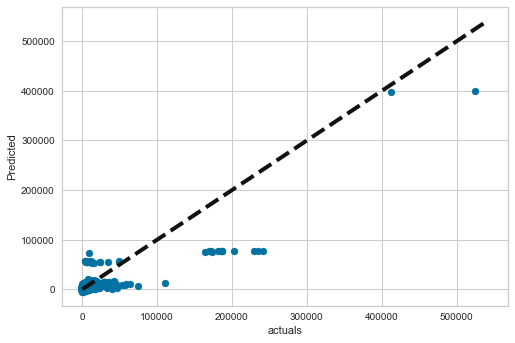

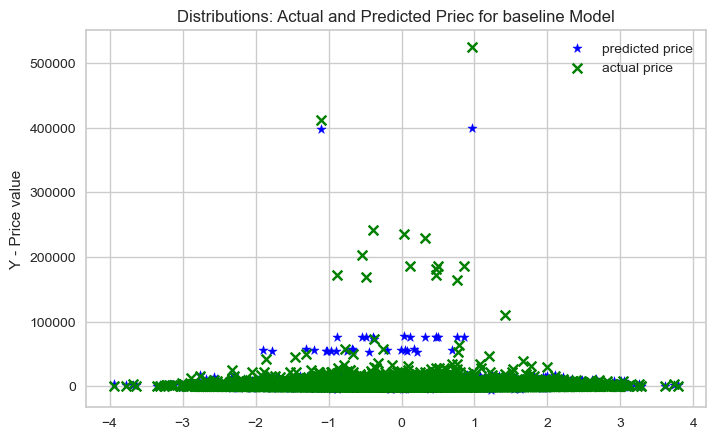

In [25]:
## graph for distribution of values 
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('actuals')
ax.set_ylabel('Predicted')
plt.show()


x = np.random.randn(len(y_pred))
y1 = y_pred
y2 = y_test
#y3 = np.random.poisson(5, 500)

# Plot
plt.rcParams.update({'figure.figsize':(8,5), 'figure.dpi':100})
plt.scatter(x,y1,color='blue', marker= '*', label='predicted price')
plt.scatter(x,y2,color= 'green', marker='x', label='actual price')

# Decorate
plt.title('Distributions: Actual and Predicted Priec for baseline Model')
plt.ylabel('Y - Price value')
plt.legend(loc='best')
plt.show()

### Better
Using yellowbrick library for better graphs

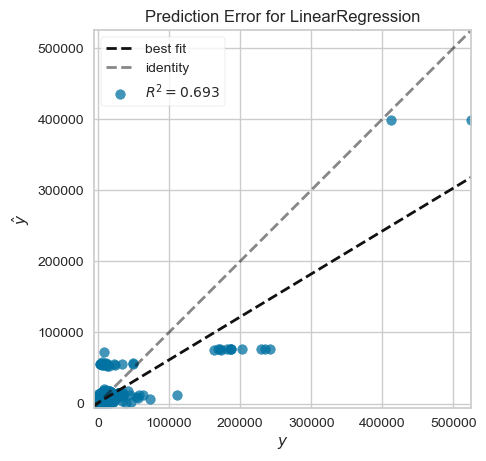

<AxesSubplot:title={'center':'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [26]:
visualizer = PredictionError(baseline_model)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()   

In [27]:
#pip install yellowbrick

# Model1. 

In [28]:
## Random Forest with 100 decision tress 
rf_model = RandomForestRegressor(n_estimators=100, random_state = 0)

# fit the model with feature set and target
rf_model.fit(X_train, y_train)

# predict the value from X_test set
y_pred = rf_model.predict(X_test)

In [29]:
# what is the r2_score for the model
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

print("This is r2_score for random forest model:", r2_score(y_pred, y_test))
print("This is RMSE score", mean_squared_error(y_pred, y_test, squared=False))
print("-----------------------------")
print("-----------Assignment condition------------------")
print("Total predicted sum", y_pred.sum())
print("Total actual sum", y_test.sum())
print("Is predicted reveue higher the actual?....", y_pred.sum() > y_test.sum())

This is r2_score for random forest model: 0.9503971866237717
This is RMSE score 1941.792631910536
-----------------------------
-----------Assignment condition------------------
Total predicted sum 34964339.338375404
Total actual sum 34956355.979944214
Is predicted reveue higher the actual?.... True


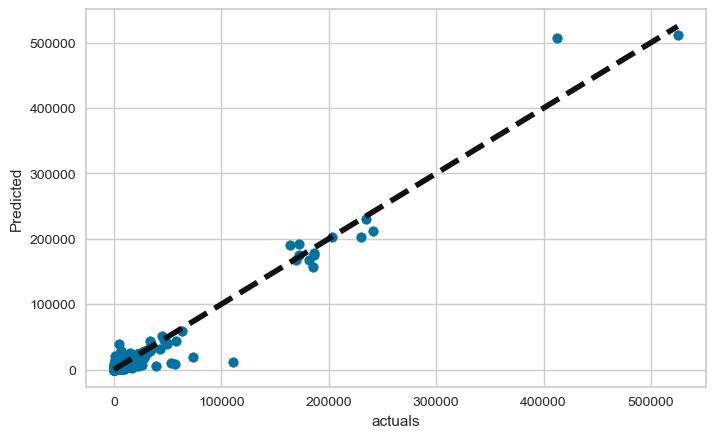

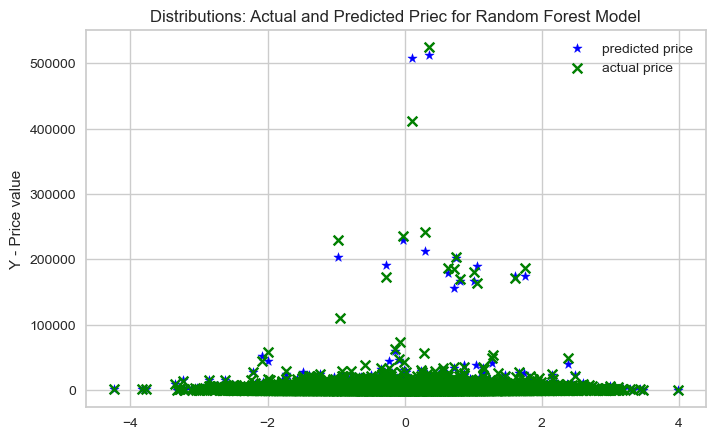

In [30]:
## graph for distribution of values 
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('actuals')
ax.set_ylabel('Predicted')
plt.show()

x = np.random.randn(len(y_pred))
y1 = y_pred
y2 = y_test
#y3 = np.random.poisson(5, 500)

# Plot
plt.rcParams.update({'figure.figsize':(8,5), 'figure.dpi':100})
plt.scatter(x,y1,color='blue', marker= '*', label='predicted price')
plt.scatter(x,y2,color= 'green', marker='x', label='actual price')

# Decorate
plt.title('Distributions: Actual and Predicted Priec for Random Forest Model')
plt.ylabel('Y - Price value')
plt.legend(loc='best')
plt.show()

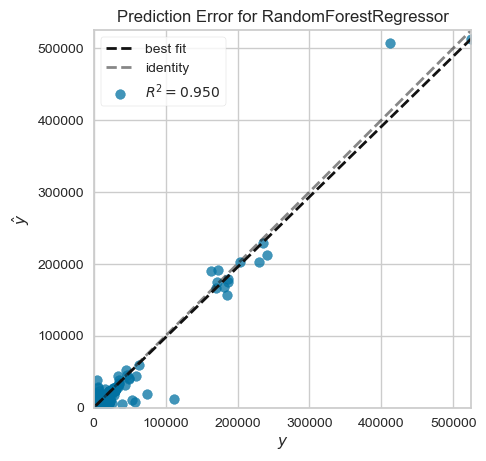

<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [31]:
visualizer = PredictionError(rf_model)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()   

### Model Interpretability
LIME, SHAP, Feature importance

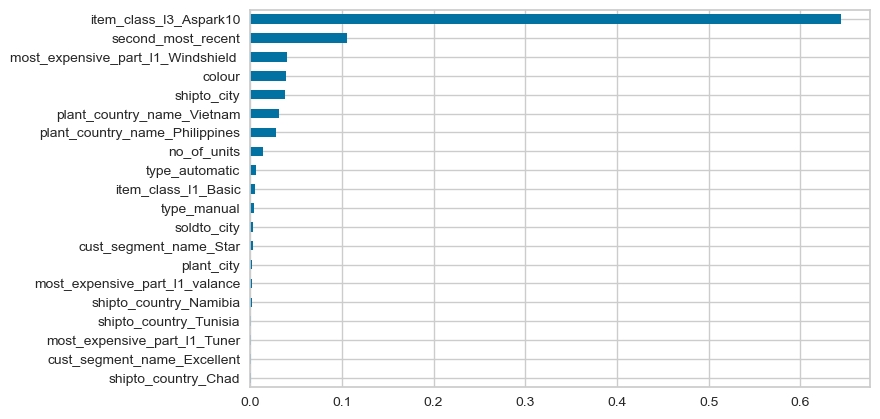

In [32]:
## Feature importance  - Top 20 features 
#plot graph of feature importances for better visualization
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).sort_values().plot(kind='barh')
plt.show()


### Verdict of Random Forest: 

    This is r2_score for random forest model: 0.9564447406516668
    This is RMSE score 2355.764457371224
    -----------------------------
    -----------Assignment condition------------------
    Total predicted sum 37181524.26446545
    Total actual sum 36961320.4362275
    Is predicted reveue higher the actual?.... True
    
What next:  
As discussed in hypothesis that second most recent transaction has huge influence, we can see that from the feature imporatance, But we also see that one feature from item_class_l3 is influencing model significantly.  We shall treat this feature. 

let us run xgboost on same data before changing features and data
  
  

# Model2. 

We are going to use xgboost model to see if it performs better on the given data

In [33]:
## let us change the gear and use more complex algo    
model = XGBRegressor(n_estimators= 500, max_depth=15, eta=0.1, subsample=0.7, colsample_bytree=0.8, alpha = 0.1)

# model training
model.fit(X_train, y_train)

# predict the prices for X_test dataset
y_pred = model.predict(X_test)

In [34]:
# what is the r2_score for the model
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

print("This is r2_score for baseline model:", r2_score(y_pred, y_test))
print("This is RMSE score", mean_squared_error(y_pred, y_test, squared=False))
print("-----------------------------")
print("-----------Assignment condition------------------")
print("Total predicted sum", y_pred.sum())
print("Total actual sum", y_test.sum())
print("Is predicted reveue higher the actual?....", y_pred.sum() > y_test.sum())

This is r2_score for baseline model: 0.949127199325616
This is RMSE score 1990.092978225683
-----------------------------
-----------Assignment condition------------------
Total predicted sum 34941840.0
Total actual sum 34956355.979944214
Is predicted reveue higher the actual?.... False


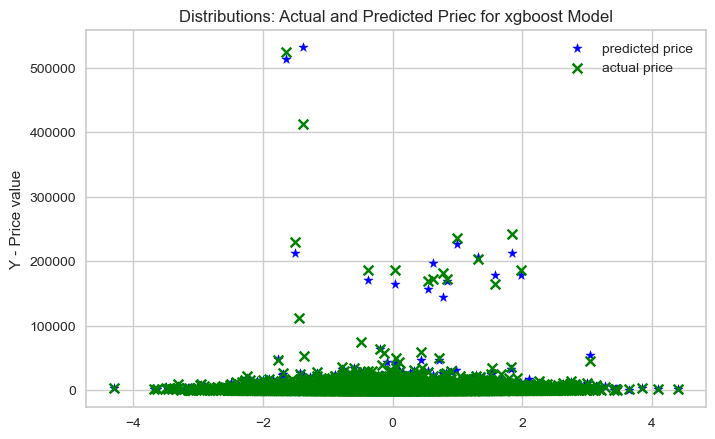

In [35]:
x = np.random.randn(len(y_pred))
y1 = y_pred
y2 = y_test
#y3 = np.random.poisson(5, 500)

# Plot
plt.rcParams.update({'figure.figsize':(8,5), 'figure.dpi':100})
plt.scatter(x,y1,color='blue', marker= '*', label='predicted price')
plt.scatter(x,y2,color= 'green', marker='x', label='actual price')

# Decorate
plt.title('Distributions: Actual and Predicted Priec for xgboost Model')
plt.ylabel('Y - Price value')
plt.legend(loc='best')
plt.show()

## Let us look on inference data and prediction now

In [36]:
## Test the inference for the datapoints we have taken out from the set itself
final_inference.head()

,type_of_sale,unit_price_inK,second_most_recent,no_of_units,colour,plant_city,shipto_city,soldto_city,booking_to_delivery_date_immediate,booking_to_delivery_date_long,...,soldto_country_Mozambique,soldto_country_Namibia,soldto_country_Niger,soldto_country_Nigeria,soldto_country_Senegal,soldto_country_Somalia,soldto_country_South Africa,soldto_country_Sudan,soldto_country_Tanzania,soldto_country_Zambia
37700,retail,1393.92,0.000000,5.883434,16,25,527,199,0,1,...,0,0,0,0,1,0,0,0,0,0
37701,retail,1456.84,7.240592,7.779450,16,25,527,199,0,1,...,0,0,0,0,1,0,0,0,0,0
36255,retail,418.00,0.000000,7.919356,16,2,330,126,0,1,...,0,0,0,0,0,0,0,0,0,0
36254,retail,418.00,6.037871,7.513851,16,2,330,126,0,1,...,0,0,0,0,0,0,0,0,0,0
37702,retail,1390.84,7.284711,8.101678,16,25,527,199,0,1,...,0,0,0,0,1,0,0,0,0,0


In [37]:
# assign data to featureset and target variable
X_final = final_inference.drop(['unit_price_inK', 'type_of_sale'], axis=1)
y_final = final_inference['unit_price_inK']

In [38]:
X_final.shape

(20, 218)

In [39]:
# predict the prices for X_test dataset
rf_model_y_pred = rf_model.predict(X_final)

# predict the prices for X_test dataset
baseline_model_y_pred = baseline_model.predict(X_final)

# predict the prices for X_test dataset
xgb_model_y_pred = model.predict(X_final)

In [40]:
# what is the r2_score for the model
print("This is r2_score for xgboost model:", r2_score(xgb_model_y_pred, y_final))

# what is the r2_score for the model
print("This is r2_score for randomForest model:", r2_score(rf_model_y_pred, y_final))

# what is the r2_score for the model
print("This is r2_score for baseline model:", r2_score(baseline_model_y_pred, y_final))

# what is the r2_score for the model
print("This is RMSE for baseline model:", mean_squared_error(baseline_model_y_pred, y_final, squared=False))

# what is the r2_score for the model
print("This is RMSE for RF model:", mean_squared_error(rf_model_y_pred, y_final, squared=False))

# what is the r2_score for the model
print("This is RMSE for xgboost model:", mean_squared_error(xgb_model_y_pred, y_final, squared=False))



print("-----------------------------")
print("-----------Assignment condition------------------")
print("Total predicted sum from baseline", baseline_model_y_pred.sum())
print("Total predicted sum from RF", rf_model_y_pred.sum())
print("Total predicted sum from xgboost", xgb_model_y_pred.sum())
print("Total actual sum", y_final.sum())
print("Is predicted reveue higher the actual for Random Forest?....", rf_model_y_pred.sum() > y_final.sum())


This is r2_score for xgboost model: 0.4814034674385602
This is r2_score for randomForest model: 0.6576091183556172
This is r2_score for baseline model: -0.4889170870431485
This is RMSE for baseline model: 1088.9708986286446
This is RMSE for RF model: 322.44121398124383
This is RMSE for xgboost model: 373.7867401256988
-----------------------------
-----------Assignment condition------------------
Total predicted sum from baseline 12065.850662985258
Total predicted sum from RF 18919.50740999
Total predicted sum from xgboost 17452.93
Total actual sum 20679.12
Is predicted reveue higher the actual for Random Forest?.... False


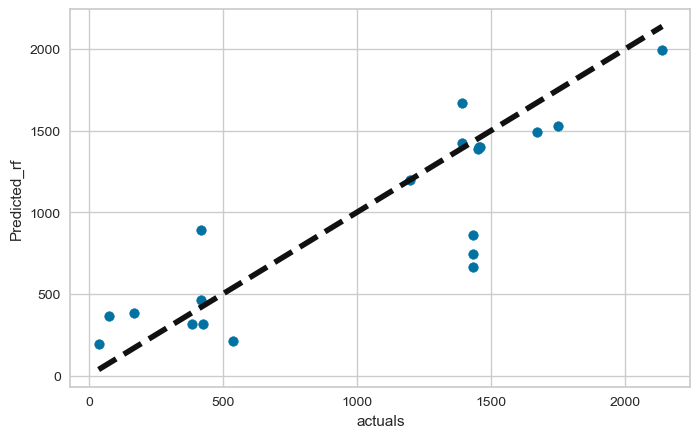

In [41]:
## graph for distribution of values 
fig, ax = plt.subplots()
ax.scatter(y_final, rf_model_y_pred)
ax.plot([y_final.min(), y_final.max()], [y_final.min(), y_final.max()], 'k--', lw=4)
ax.set_xlabel('actuals')
ax.set_ylabel('Predicted_rf')
plt.show()

## Graph
Random Forest has been doing quite good in the models, we will focus on random forest for more experiments and optimization.

## Issue with this model - randomForest
    - Seems a case of underfitting 
    - 2 features are getting very high value in feature score 
    - Model is trained with wholesale dataset as well so we can try one experiment with the train and test with only retail customers. 

# Recommendations for Future Enhancement

1. We can try SVM Regressor 
2. Try to reduce the dimension of the data
3. Build and test the model based on car class - Basic, Mid-range, Premium 
4. Outliers need to be handled with the help of SMEs.